LIME version: 0.2.0.1
Scikit-learn version: 1.3.0
Pandas version: 2.0.3
Numpy version: 1.25.2

--- Loading and Preparing Data ---
Training set samples: 120
Test set samples: 30
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Class names: ['setosa' 'versicolor' 'virginica']
Data loading and preparation complete.

--- Training the Model ---
Model training complete.

--- Creating LIME Tabular Explainer ---
LIME Explainer created.

--- Explaining a Single Instance ---
Instance index to explain: 0
Instance feature values: [6.1 2.8 4.7 1.2]
Instance true class: versicolor (index: 1)
Model predicted class: versicolor (index: 1)
Model prediction probabilities for each class: [0.   0.99 0.01]
LIME explanation generated.

--- LIME Explanation for Instance 0 (Model Prediction: versicolor) ---
Explanation is for class: versicolor
Feature contribution weights (Positive values support the predicted class, negative values oppose):
  Feature condition:

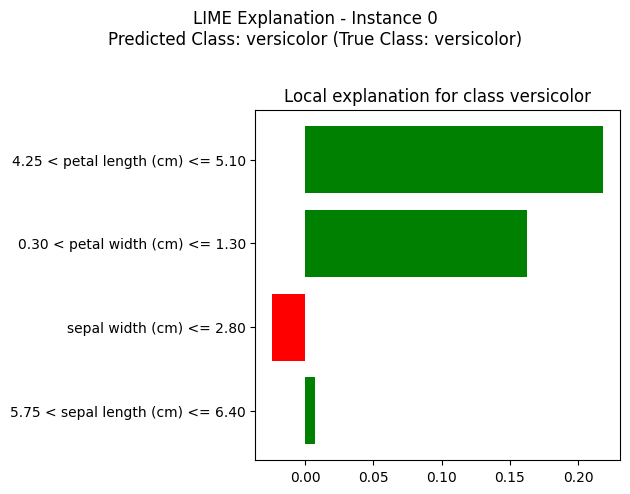


Explanation saved to HTML file: lime_iris_instance_0_explanation.html


In [1]:
# Step 1: Import Necessary Libraries
import lime
import lime.lime_tabular # LIME explainer for tabular data
import sklearn
from sklearn.datasets import load_iris # Using the classic Iris dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # We'll use RandomForest as our black-box model
import numpy as np
import pandas as pd # Optional, for initial data exploration
import matplotlib.pyplot as plt # For displaying LIME-generated plots
import importlib.metadata # For fetching package versions

# Print library versions
try:
    lime_version = importlib.metadata.version('lime') # Correct way to get LIME version
    print(f"LIME version: {lime_version}")
except importlib.metadata.PackageNotFoundError:
    print("LIME library is installed, but version could not be determined via importlib.metadata.")
    print("You can often check with 'pip show lime' in your terminal.")

print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}") # Print Pandas version if used
print(f"Numpy version: {np.__version__}")   # Print Numpy version

# Step 2: Load and Prepare Data
print("\n--- Loading and Preparing Data ---")
iris = load_iris()
X = iris.data # Feature data (numpy array)
y = iris.target # Target labels (numpy array)
feature_names = iris.feature_names # List of feature names
class_names = iris.target_names    # List of class names ('setosa', 'versicolor', 'virginica')

# Split data into training and testing sets
# LIME's LimeTabularExplainer typically uses training data to learn feature distributions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set samples: {X_train.shape[0]}")
print(f"Test set samples: {X_test.shape[0]}")
print(f"Feature names: {feature_names}")
print(f"Class names: {class_names}")
print("Data loading and preparation complete.\n")

# Step 3: Train a Black-Box Model
print("--- Training the Model ---")
# We use a RandomForestClassifier as an example
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model training complete.\n")

# Step 4: Create LIME Explainer
print("--- Creating LIME Tabular Explainer ---")
# LimeTabularExplainer is used for structured (tabular) data.
# Key parameters:
# - training_data: Training data (NumPy array) used to learn feature distributions. LIME samples from this.
# - feature_names: List of feature names.
# - class_names: List of target class names (for classification tasks).
# - mode: 'classification' or 'regression'.
# - discretize_continuous: If True, continuous features are discretized,
#   making explanations based on feature bins (e.g., "feature > value"), which is often more interpretable.
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)
print("LIME Explainer created.\n")

# Step 5: Explain a Single Prediction
print("--- Explaining a Single Instance ---")
# Select an instance from the test set to explain
instance_idx = 0 # We choose the first sample in the test set
instance_to_explain = X_test[instance_idx] # This is a 1D NumPy array
true_class_idx = y_test[instance_idx]
true_class_name = class_names[true_class_idx]

# Get the model's prediction probabilities and predicted class for this instance
model_prediction_proba = model.predict_proba(instance_to_explain.reshape(1, -1))
predicted_class_idx = np.argmax(model_prediction_proba) # Index of the class with the highest probability
predicted_class_name = class_names[predicted_class_idx]

print(f"Instance index to explain: {instance_idx}")
print(f"Instance feature values: {instance_to_explain}")
print(f"Instance true class: {true_class_name} (index: {true_class_idx})")
print(f"Model predicted class: {predicted_class_name} (index: {predicted_class_idx})")
print(f"Model prediction probabilities for each class: {model_prediction_proba[0]}")


# Define the predict_fn function:
# LIME requires a function that takes a NumPy array of perturbed samples
# and returns the probability for each class for these samples (for classification).
# For scikit-learn classifiers, this is usually the model.predict_proba method.
predict_fn = lambda x: model.predict_proba(x)

# Generate the explanation for the selected instance using the explainer
# Key parameters:
# - data_row: The single instance to explain (1D NumPy array).
# - predict_fn: The prediction function defined above.
# - num_features: The number of most important features to include in the explanation.
# - top_labels: (Optional) Specifies which top N labels to explain. For example, top_labels=1
#   means explain only the class with the highest predicted probability.
#   If not specified, LIME might try to explain all classes or you can provide a list of labels.
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=predict_fn,
    num_features=len(feature_names), # Show contributions for all features
    top_labels=1 # We are interested in why the model predicted the top class
)
print("LIME explanation generated.\n")

# Step 6: Visualize and Interpret the Explanation
# LIME explains which features (and their specific value ranges, if discretized)
# contributed most to the model's prediction for this instance.
# Positive weights mean the feature (or its value range) supports the predicted class.
# Negative weights mean the feature (or its value range) opposes the predicted class (i.e., supports other classes).

# Get the index of the label that LIME primarily explained
# If top_labels was set in explain_instance, explanation.top_labels[0] is that label's index.
explained_label_idx = explanation.top_labels[0] if explanation.top_labels else predicted_class_idx

print(f"--- LIME Explanation for Instance {instance_idx} (Model Prediction: {predicted_class_name}) ---")
print(f"Explanation is for class: {class_names[explained_label_idx]}")
print("Feature contribution weights (Positive values support the predicted class, negative values oppose):")
# explanation.as_list(label=...) returns a list of (feature_description, weight) tuples
for feature_description, weight in explanation.as_list(label=explained_label_idx):
    print(f"  Feature condition: \"{feature_description}\", Weight: {weight:.4f}")

# Visualize the explanation
# LIME can generate an HTML file, display directly in a Jupyter Notebook, or generate a matplotlib figure.
try:
    # Display the explanation as a matplotlib figure
    fig = explanation.as_pyplot_figure(label=explained_label_idx)
    fig.suptitle(f"LIME Explanation - Instance {instance_idx}\nPredicted Class: {predicted_class_name} (True Class: {true_class_name})", y=1.02) # y > 1 positions title above plot
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    # Save the explanation to an HTML file, which often provides a richer, interactive visualization
    html_explanation_file = f"lime_iris_instance_{instance_idx}_explanation.html"
    explanation.save_to_file(html_explanation_file)
    print(f"\nExplanation saved to HTML file: {html_explanation_file}")

except Exception as e:
    print(f"Could not generate plot or HTML file: {e}")
    print("Please ensure matplotlib is installed and you are in a suitable environment (e.g., Jupyter Notebook for optimal HTML visualization).")
    print("The text explanation above is still available if visualization failed.")